# Learning Specification from User Demonstration on System

In this notebook, we're going to explore learning a known specification from demonstrations of the known specification on the product of the specification and a transition system model for a simple environment.

We will then apply the learned specification to an environment with a different robot / environmental dynamics, but with the same intended goal as in the environment where we demonstrated the task.

This shows that we can actually learn the intended task the user had in mind when they demonstrate it on a system with actual dynamics, and then apply that specification to a different environment.

In [2]:
%load_ext autoreload

import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split

# wombats imports
from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface

## Loading in the Desired LTL-style PDFA Specification

We're going to assume the user has some task in mind that can be expressed as some form of complicated LTL formula that has been translated to a DFA with probabilistic weights to encode their task preferences.

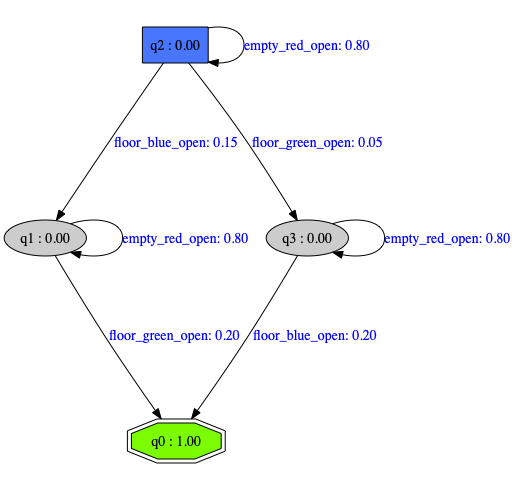

In [3]:
pdfa_config_file = 'wombats/config/PDFA_minigrid_synthesis_meeting.yaml'
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=pdfa_config_file)
pdfa_specification.draw('basic_minigrid_pdfa')

## Loading in the Simplified Transition System for Demonstration

We are going to demonstrate this specification using a simplified robot that can only go in each cardinal direction

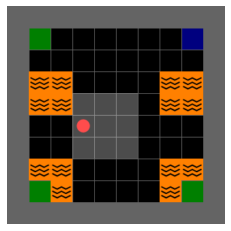

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:620: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


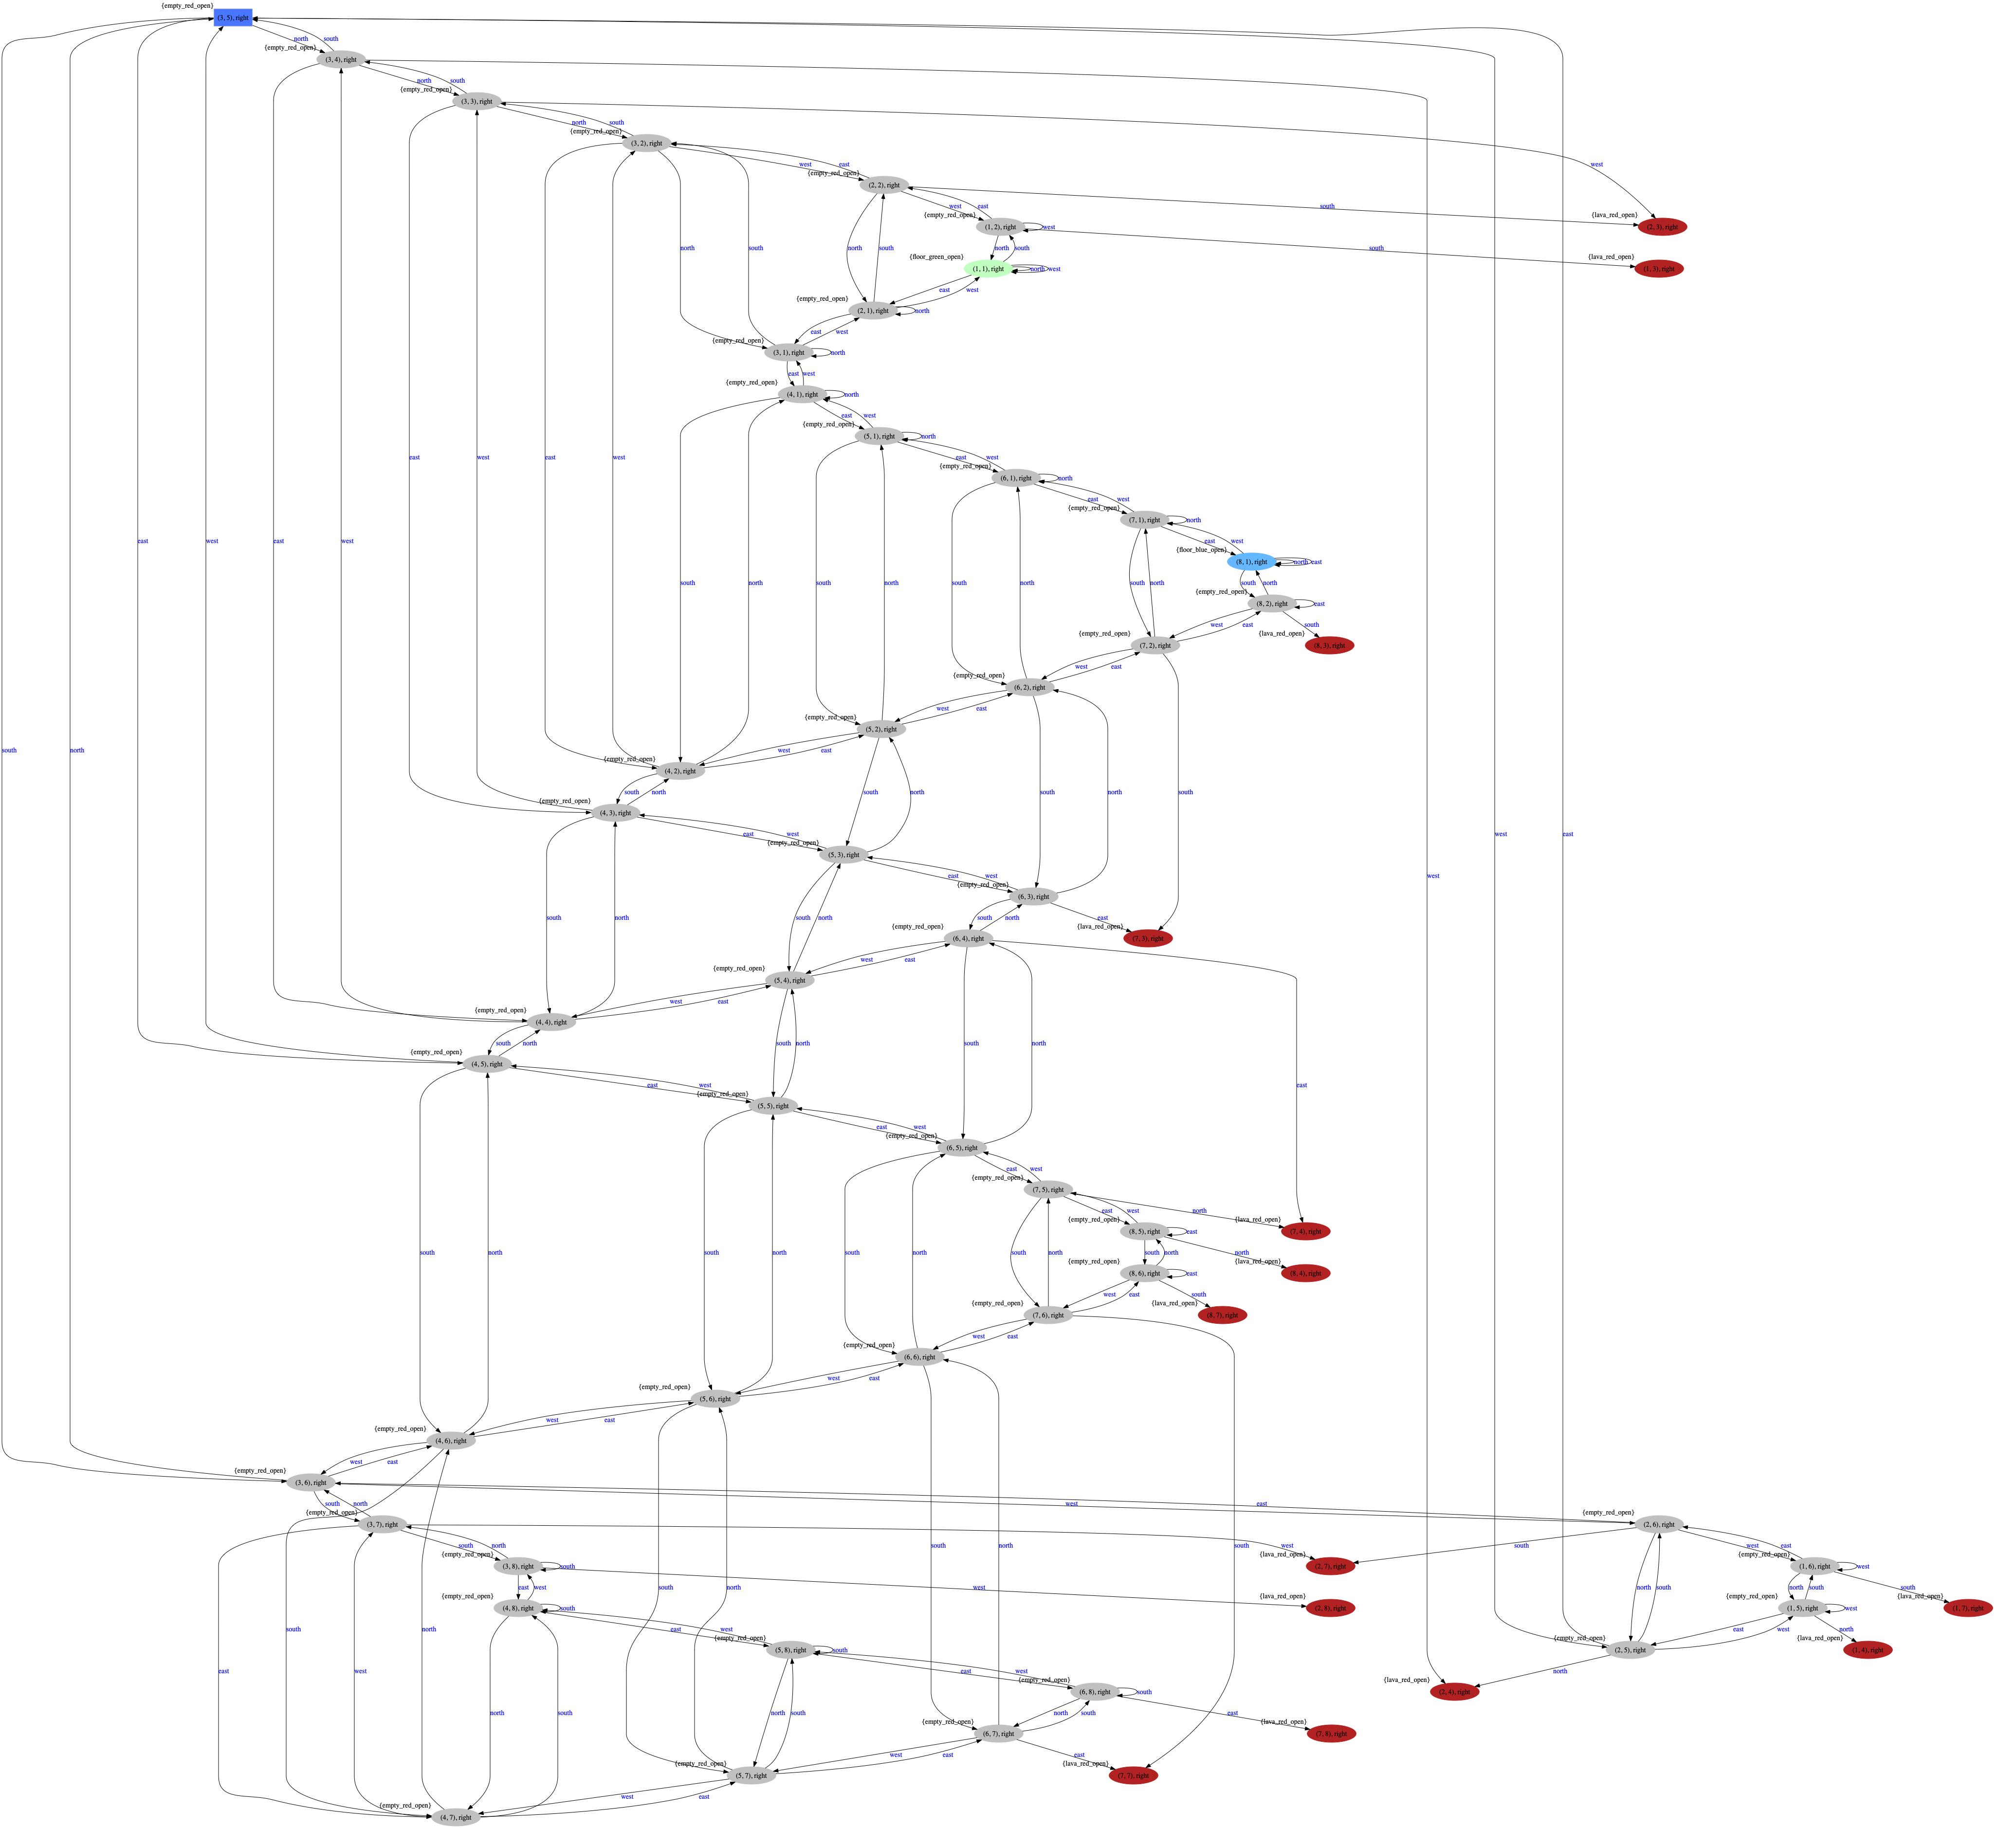

In [4]:
ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
env = gym.make(ENV_ID)

env = StaticMinigridTSWrapper(env, actions_type='simple_static')
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
minigrid_TS.draw('_'.join([ENV_ID, 'TS']))

In [5]:
minigrid_TS.observations

{'empty_red_open', 'floor_blue_open', 'floor_green_open', 'lava_red_open'}

In [6]:
list(minigrid_TS.actions)

[<SimpleStaticActions.north: 0>,
 <SimpleStaticActions.south: 1>,
 <SimpleStaticActions.east: 2>,
 <SimpleStaticActions.west: 3>]

## Generating Correct System Demonstrations

Here, we are now going to sample behavioral demonstrations of the robot in its environment that adhere to the given specification.

### Building the Product Automaton
To create demonstrations of the specification as applied to the simple robot & env. from above, we are going to start by taking their product 

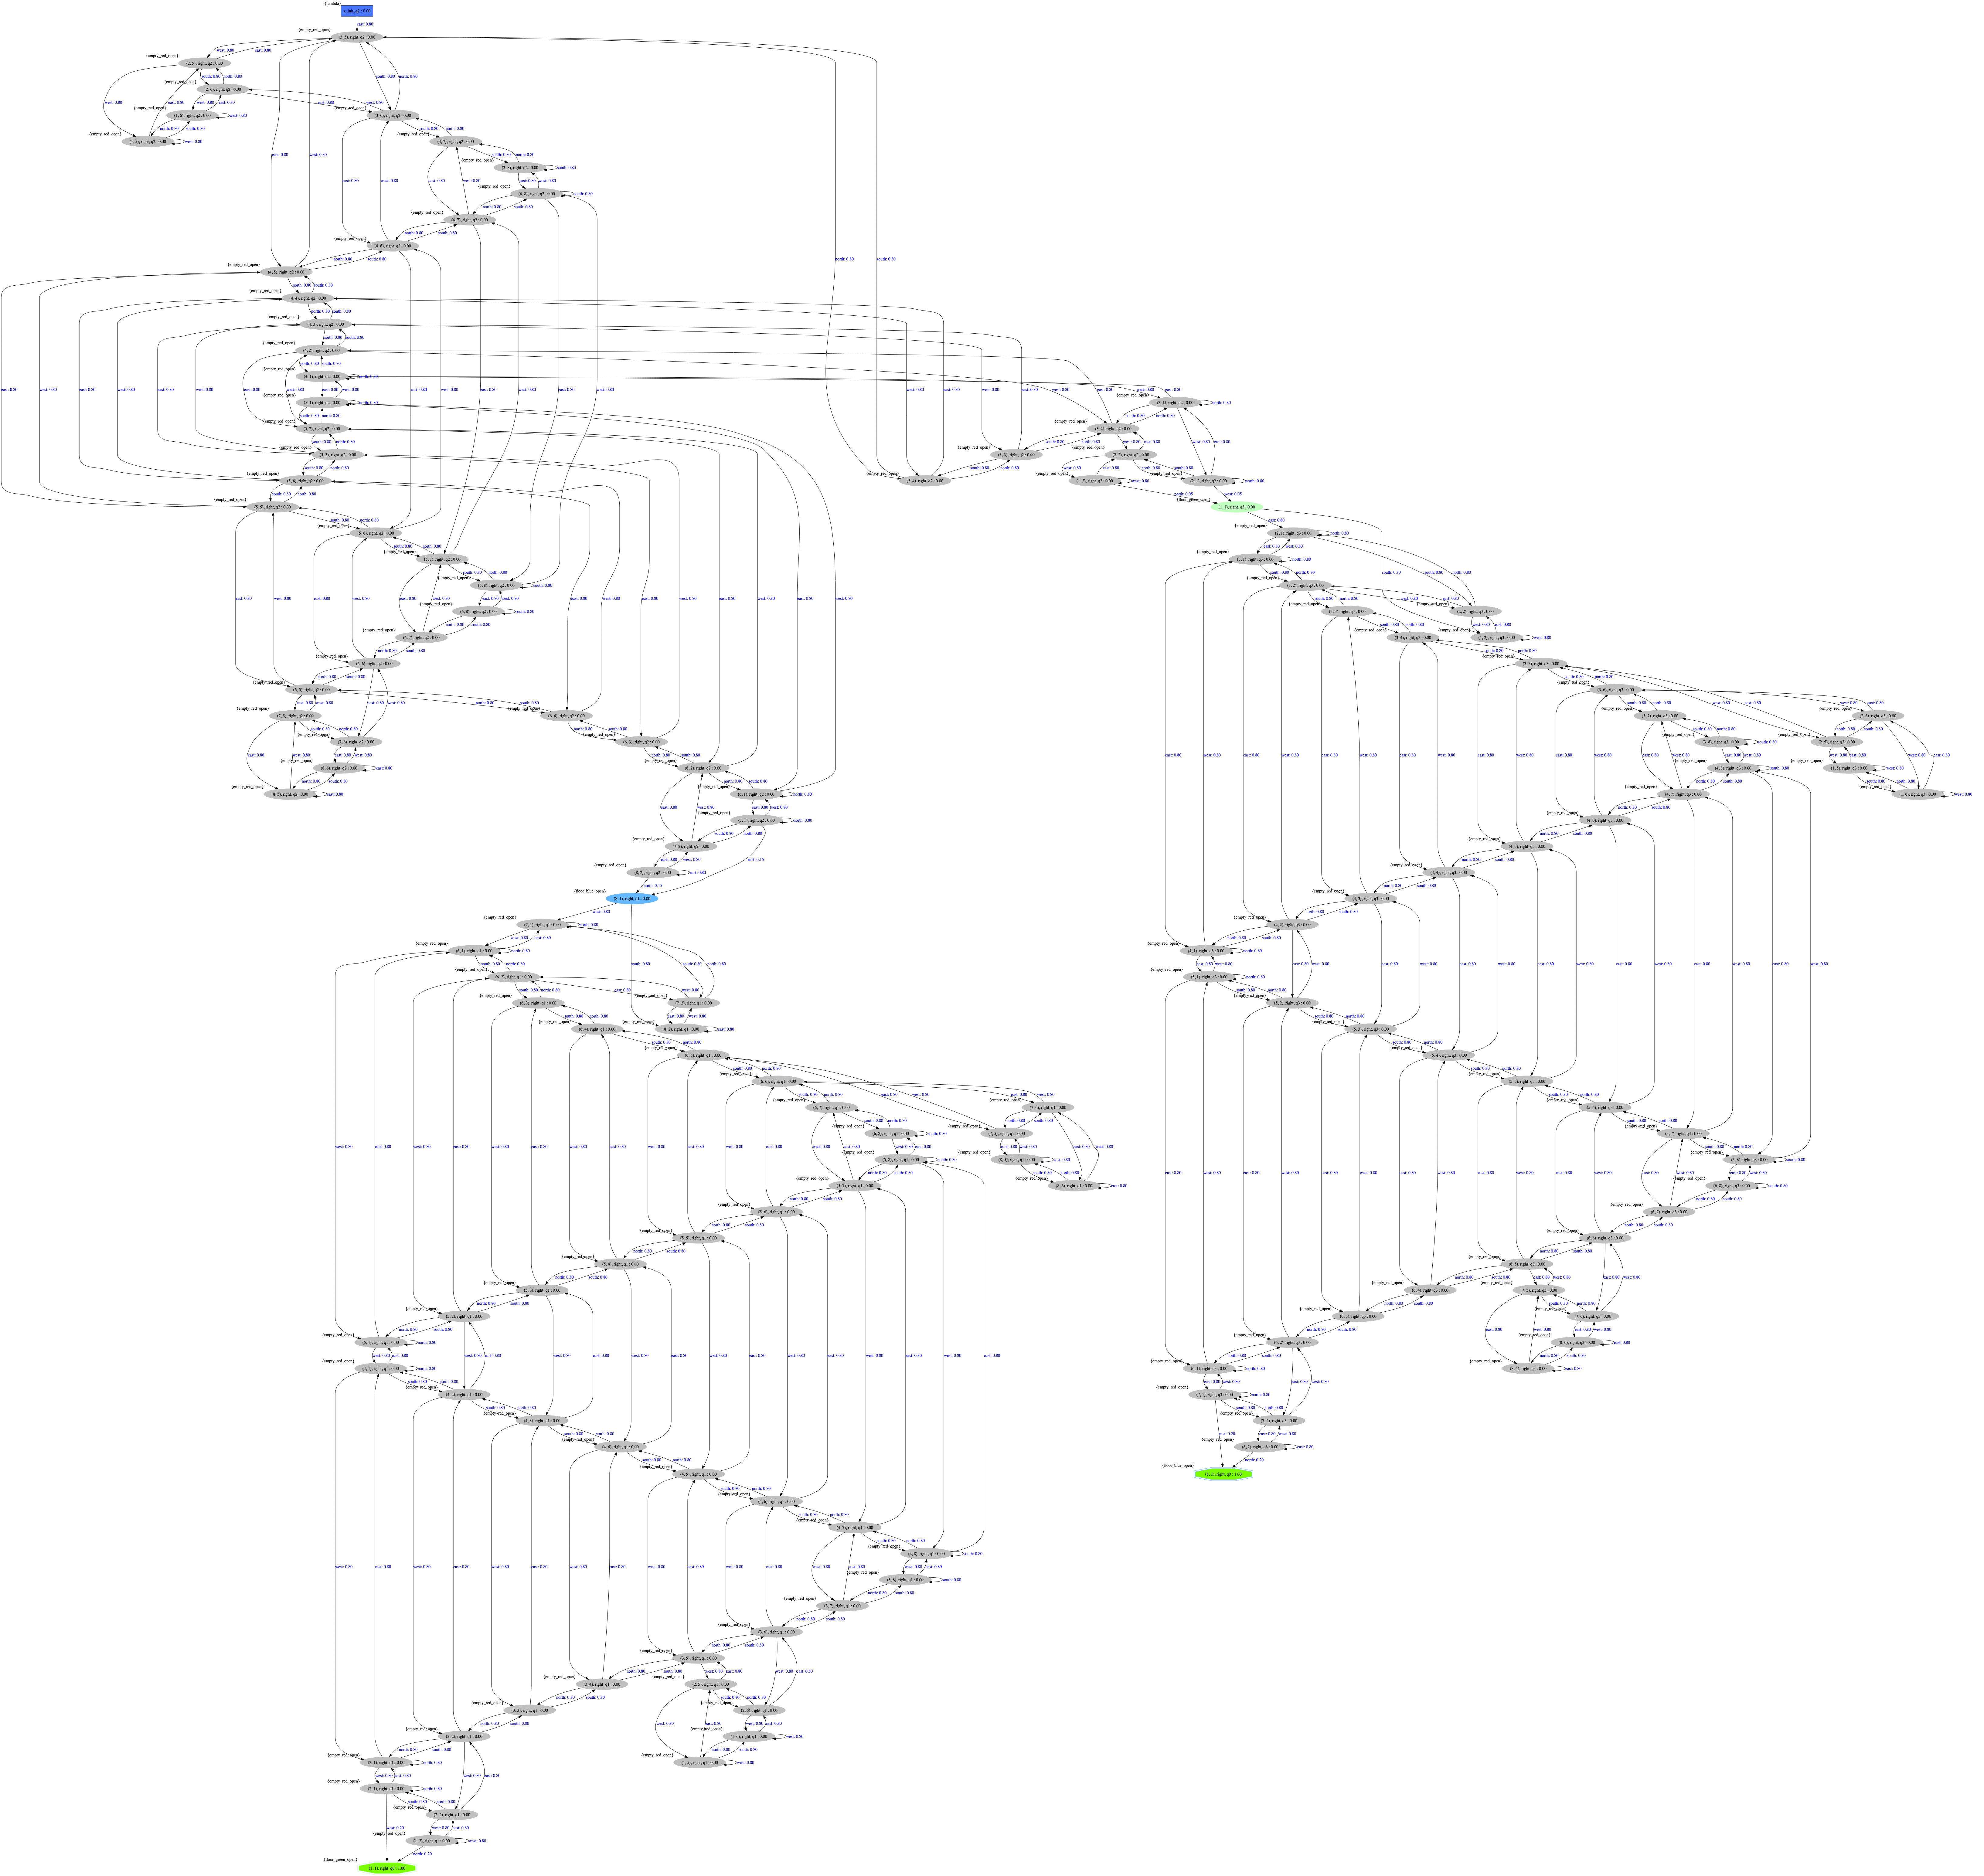

In [7]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          pdfa_specification),
                             show_steps=False)
product.draw('_'.join([ENV_ID, '_basic_product']))

### Generating and Saving Behavioral Demonstrations

To generate demonstration runs on the product that have the the same projected probability as those from the specification, we need to sample strings from the product. This is not straightforward, as the product does not have a valid probability distribution at each state. Thus, we employ the following technique:

* 
* Use the `BMPS` algorithm, but 

## Learning the Specification

We will take this specification and learn it using `Flexfringe`

### Creating Training / Test Data

Here, we choose a 90/10 training/test split in our data using N samples fron the target specification.

In [3]:
num_samples = 50
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
num_traces_train = len(traces_train)
num_traces_test = len(traces_test)
pdfa_specification.write_traces_to_file(traces_train, num_traces_train,
                                        traceLengths_train,
                                        f_name='meeting_minigrid_pdfa_train')
pdfa_specification.write_traces_to_file(traces_test, num_traces_test,
                                        traceLengths_test,
                                        f_name='meeting_minigrid_pdfa_test')

### Learning with `Flexfringe`

We are going to use the wombats wrapper to learn the specification.

In [4]:
flexfringe = FlexfringeInterface()
flexfringe.infer_model(get_help=True)

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=10 -x=0 -w=1 -a=1 -b=1 -f=1 -I=0 -t=1 -q=0 -y=0 -p=0.5 --output-dir=./dfa meeting_minigrid_pdfa_train 
sat_program : 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99963  x81  m99980  x36  

found intermediate solution with 3 and 3 red states
No valid solver specified, skipping...
dfasat running 

found intermediate solution with 3 and 1 red states
No valid solver specified, skipping...
dfasat running 

found intermediate solution with 3 and 1 red states
No valid

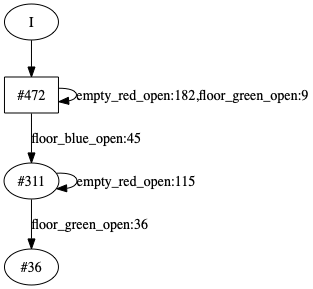

In [5]:
%autoreload 2
data = flexfringe.infer_model(training_file='meeting_minigrid_pdfa_train',
                              h='kldistance',
                              d='kl_data',
                              n='10',
                              x='0',
                              w='1',
                              a='1',
                              b='1',
                              f='1',
                              I='0',
                              t='1',
                              q='0',
                              y='0',
                              p='0.5')

flexfringe.draw_learned_model()

### Loading in / Processing the Learned Specification

The result from Flexfringe is NOT even an FDFA, so we must do a lot of processing to turn it into a proper PDFA:

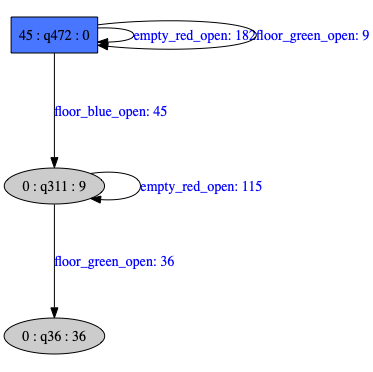

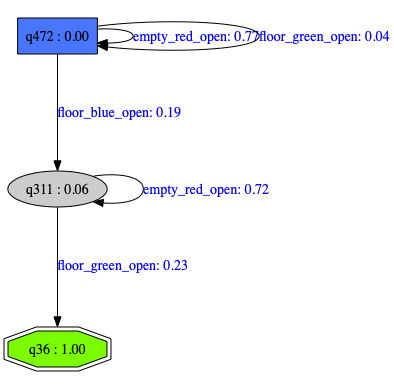

In [6]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_fdfa.draw('meeting_robot_learned_spec_fdfa')

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   smooth_transitions=False,
                                   smoothing_amount=0.0000)
learned_pdfa.draw('meeting_robot_learned_spec_fdfa')

In [7]:
learned_pdfa._num_states

3

## Evaluating Learned Specification

We start by checking how different the most probable string is for the learned PDFA vs. the learning target.

In [8]:
(specification_MPS,
 specification_MPS_prob) = pdfa_specification.most_probable_string()
print(f'Specification MPS: {specification_MPS}')
print(f'Probability of Spec. MPS in PDFA"s Language: {specification_MPS_prob}')

learned_model_MPS, learned_model_MPS_prob = learned_pdfa.most_probable_string()
print(f'Learned MPS: {learned_model_MPS}')
print(f'Probability of Learned MPS in PDFA"s Language: {learned_model_MPS_prob}')

Specification MPS: ['floor_blue_open', 'floor_green_open']
Probability of Spec. MPS in PDFA"s Language: 0.03
Learned MPS: ['floor_blue_open', 'floor_green_open']
Probability of Learned MPS in PDFA"s Language: 0.04290254237288135


We also want to evaluate the learned LM's perplexity on the test set given the exact, know string probabilities from the learning target:

In [9]:
test_perplexity = learned_pdfa.perplexity(traces_test, trace_probs_test)
train_perplexity = learned_pdfa.perplexity(traces_train, trace_probs_train)
target_perplexity = pdfa_specification.perplexity(traces_test, trace_probs_test)

print(f"Test Perplexity of Learned Model: {test_perplexity}")
print(f"Training Perplexity of Learned Model: {train_perplexity}")
print(f"Perplexity of Target Model: {target_perplexity}")

Test Perplexity of Learned Model: 1.029793231935059
Training Perplexity of Learned Model: 1.0380485645102357
Perplexity of Target Model: 1.0289139866636532


## Loading in the Minigrid Transition System

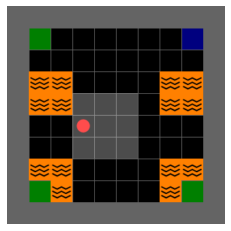

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:620: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


In [10]:
ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
# ENV_ID = 'MiniGrid-DistShift1-v0'
# ENV_ID = 'MiniGrid-LavaGapS5-v0'
# ENV_ID = 'MiniGrid-KeyCorridorS3R1-v0'
env = gym.make(ENV_ID)

env = StaticMinigridTSWrapper(env, actions_type='simple_static')
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
# minigrid_TS.draw('_'.join([ENV_ID, 'TS']))

In [11]:
minigrid_TS.observations

{'empty_red_open', 'floor_blue_open', 'floor_green_open', 'lava_red_open'}

In [12]:
list(minigrid_TS.actions)

[<SimpleStaticActions.north: 0>,
 <SimpleStaticActions.south: 1>,
 <SimpleStaticActions.east: 2>,
 <SimpleStaticActions.west: 3>]

## Building the Product Automaton

In [13]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)
# product.draw('_'.join([ENV_ID, '_basic_product']))

In [14]:
product.observations

{'empty_red_open', 'floor_blue_open', 'floor_green_open', 'lambda'}

## Computing the Most-Probable, Possible Controller

In [15]:
%autoreload 2
(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

Optimal Controls: ['north', 'north', 'north', 'north', 'east', 'east', 'east', 'east', 'east']
Probability of Generated TS Observations in Spec: 0.0010348025797183996


## Applying Controller to System

In [16]:
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_blue_open']
['(3, 5), right', '(3, 4), right', '(3, 3), right', '(3, 2), right', '(3, 1), right', '(4, 1), right', '(5, 1), right', '(6, 1), right', '(7, 1), right', '(8, 1), right']
